In [1]:
!wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/train_8M.csv
!wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/transactions.csv
!wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/holidays_events.csv
!wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/items.csv
!wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/oil.csv
!wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/stores.csv
!wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/recmetrics.zip
!unzip recmetrics.zip

--2019-07-26 06:56:43--  https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/train_8M.csv
Resolving huseinhouse-storage.s3-ap-southeast-1.amazonaws.com (huseinhouse-storage.s3-ap-southeast-1.amazonaws.com)... 52.219.40.103
Connecting to huseinhouse-storage.s3-ap-southeast-1.amazonaws.com (huseinhouse-storage.s3-ap-southeast-1.amazonaws.com)|52.219.40.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274094162 (261M) [text/csv]
Saving to: ‘train_8M.csv’

train_8M.csv        100%[===================>] 261.40M  10.6MB/s    in 39s     

2019-07-26 06:57:23 (6.78 MB/s) - ‘train_8M.csv’ saved [274094162/274094162]

--2019-07-26 06:57:25--  https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/transactions.csv
Resolving huseinhouse-storage.s3-ap-southeast-1.amazonaws.com (huseinhouse-storage.s3-ap-southeast-1.amazonaws.com)... 52.219.32.31
Connecting to huseinhouse-storage.s3-ap-southeast-1.amazonaws.com (

In [2]:
!ls

holidays_events.csv  __MACOSX  recmetrics      sample_data  train_8M.csv
items.csv	     oil.csv   recmetrics.zip  stores.csv   transactions.csv


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import tensorflow as tf
sns.set()

In [0]:
items = pd.read_csv("items.csv")
holiday_events = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv",parse_dates=['date'])
train = pd.read_csv("train_8M.csv", nrows = 500000, parse_dates=['date'])

In [0]:
stores = train['store_nbr'].values
items = train['item_nbr'].values
reward = train['unit_sales'].values

In [6]:
encoded = LabelEncoder().fit_transform(items)
items_unique = np.unique(items)
items_unique

array([  96995,  103501,  103520, ..., 1114567, 1114749, 1118683])

In [0]:
from sklearn.model_selection import train_test_split

#here different from Deep Q-learning part
train_stores, test_stores, train_items, test_items, train_reward, \
test_reward, train, test = train_test_split(stores, encoded, reward, train, test_size = 0.25)

In [8]:
LEARNING_RATE = 1e-4
LAYER_SIZE = 256
OUTPUT_SIZE = np.unique(items).shape[0]

class Model:
  def __init__(self):
    self.X = tf.placeholder(tf.int32, [None])
    self.REWARDS = tf.placeholder(tf.float32, [None])
    self.ACTIONS = tf.placeholder(tf.int32, [None])
    embeddings = tf.Variable(tf.random_uniform([np.unique(stores).shape[0], LAYER_SIZE], -1, 1))
    embedded = tf.nn.embedding_lookup(embeddings, self.X)
    feed_forward = tf.layers.dense(embedded, LAYER_SIZE, activation = tf.nn.tanh)
    self.logits = tf.layers.dense(feed_forward, OUTPUT_SIZE)
    loglike = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.ACTIONS)
    self.cost = tf.reduce_mean(loglike * self.REWARDS) 
    self.optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE).minimize(self.cost)


model = Model()

W0726 07:01:17.199734 140247683405696 deprecation.py:323] From <ipython-input-8-fba68df46aa6>:12: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0726 07:01:17.205978 140247683405696 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
sess.run([model.optimizer, model.cost], feed_dict = {model.X: train_stores[:10],
                                                    model.REWARDS: train_reward[:10],
                                                    model.ACTIONS: train_items[:10]})

[None, 43.89201]

In [11]:
train_pivoted = train.pivot_table(index='store_nbr', 
                                  columns='item_nbr', values='unit_sales').fillna(0)
train_pivoted

item_nbr,96995,103501,103520,103665,105574,105575,105576,105577,105693,105737,105857,106716,108079,108696,108698,108701,108786,108797,108831,108833,108862,108952,111223,111397,112830,114778,114790,114799,114800,115267,115611,115693,115720,115847,115850,115891,115892,115893,115894,116017,...,1101724,1102268,1102970,1102971,1102975,1102976,1104598,1104599,1104650,1104725,1105210,1105211,1105212,1105213,1105214,1105215,1105228,1105299,1105831,1106968,1109116,1109173,1109211,1109235,1109325,1109326,1109389,1109390,1109391,1110679,1111202,1112839,1112840,1113847,1113852,1113872,1114566,1114567,1114749,1118683
store_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,2.200000,2.700000,5.250000,7.636364,0.000000,2.000000,1.333333,1.909091,6.363636,2.142857,5.000000,2.500000,3.090909,2.444444,2.600000,2.000000,13.006000,0.000000,1.600000,3.000000,5.000000,9.666667,2.000000,8.454545,5.375000,1.000000,5.777778,3.125000,20.500000,2.800000,2.714286,6.333333,2.250000,3.000000,10.125000,9.714286,12.250000,7.666667,...,3.000000,3.000000,2.333333,1.666667,1.000000,2.857143,8.000000,4.222222,1.000000,4.833333,1.428571,14.700000,15.555556,26.000000,2.090909,0.0,2.500000,3.000000,0.000000,0.000000,2.500000,0.000000,0.000,0.0000,19.555556,2.400000,2.666667,2.375000,3.000000,0.000000,0.000000,0.00,0.000000,1.833333,4.833333,0.000000,0.0,0.0,1.166667,1.500000
2,1.666667,0.000000,4.222222,6.222222,9.125000,8.909091,0.000000,3.200000,1.500000,4.363636,10.875000,6.750000,2.250000,2.700000,5.555556,2.700000,3.250000,8.750000,34.749200,0.000000,1.666667,4.142857,20.555556,0.000000,4.727273,8.500000,8.250000,1.750000,15.714286,8.285714,23.181818,2.666667,5.888889,4.000000,8.818182,4.000000,12.111111,16.363636,19.111111,20.000000,...,17.500000,4.100000,1.555556,3.500000,3.666667,4.454545,4.444444,5.800000,0.000000,15.916667,3.600000,6.000000,12.000000,0.000000,3.900000,0.0,2.714286,6.750000,0.000000,0.000000,1.857143,0.000000,0.000,0.0000,15.777778,8.800000,8.363636,4.250000,3.428571,0.000000,0.000000,0.00,0.000000,4.750000,2.700000,0.000000,0.0,12.0,2.888889,1.500000
3,0.000000,0.000000,9.500000,10.428571,24.600000,13.444444,0.000000,4.300000,2.700000,7.200000,27.200000,6.833333,2.000000,7.400000,9.300000,0.000000,4.333333,15.500000,92.939846,0.000000,3.100000,6.666667,15.200000,7.500000,10.000000,23.272727,21.222222,2.888889,13.625000,9.888889,49.545455,7.909091,6.857143,15.400000,5.750000,9.000000,37.846154,45.916667,49.777778,32.700000,...,3.888889,12.800000,4.090909,3.444444,3.500000,8.833333,19.333333,10.600000,2.000000,3.000000,6.909091,54.111111,40.142857,7.111111,14.333333,0.0,4.571429,14.600000,0.000000,0.000000,3.000000,2.500000,0.000,6.6880,11.400000,10.750000,9.555556,8.166667,10.714286,0.000000,1.250000,4.00,0.000000,14.142857,14.250000,0.000000,0.0,0.0,5.454545,3.000000
4,1.666667,0.000000,3.428571,5.111111,6.750000,19.000000,0.000000,4.200000,1.333333,3.000000,8.000000,5.142857,0.000000,2.300000,5.666667,0.000000,3.714286,6.111111,23.457600,0.000000,2.666667,5.000000,19.900000,1.000000,3.200000,10.000000,9.500000,1.250000,12.545455,6.000000,11.666667,1.500000,8.250000,3.333333,12.428571,3.727273,14.272727,15.636364,17.555556,16.454545,...,2.600000,4.777778,2.000000,0.000000,2.375000,3.666667,9.111111,5.222222,0.000000,5.666667,2.636364,6.200000,8.777778,0.000000,4.000000,0.0,2.000000,3.750000,0.000000,0.000000,2.500000,0.000000,0.000,7.4390,14.600000,14.200000,9.000000,8.000000,6.500000,0.000000,1.000000,0.00,0.000000,2.833333,3.444444,0.000000,0.0,0.0,2.875000,1.000000
5,0.000000,0.000000,1.000000,5.100000,15.200000,21.750000,0.000000,9.333333,6.272727,4.125000,3.666667,3.727273,1.000000,3.222222,1.800000,4.300000,3.600000,6.250000,13.585800,0.000000,1.142857,4.000000,13.400000,0.000000,1.333333,0.000000,22.727273,2.200000,9.454545,8.625000,24.692308,2.000000,7.555556,1.125000,8.909091,2.888889,4.000000,0.000000,8.727273,15.545455,...,0.000000,8.750000,1.625000,2.125000,2.400000,1.88888

In [12]:
from tqdm import tqdm
epoch = 5 #can use more epoch to improve accuracy
batch_size = 128

for e in range(epoch):
  pbar = tqdm(
      range(0, len(train_stores), batch_size), desc = 'train minibatch loop'
    )
  loss = []
  for i in pbar:
    index = min(i + batch_size, len(train_stores))
    batch_x = train_stores[i: index]
    actions = np.argmax(sess.run(model.logits, feed_dict = {model.X: batch_x}), axis = 1)
    batch_reward = [train_pivoted.loc[batch_x[k]].iloc[actions[k]] for k in range(len(actions))]
    _, cost = sess.run([model.optimizer, model.cost], feed_dict = {model.X: batch_x,
                                                    model.REWARDS: batch_reward,
                                                    model.ACTIONS: actions})
    pbar.set_postfix(cost = cost)
    loss.append(cost)
  print('epoch: %d, average lost: %f'%(e + 1, np.mean(loss)))

train minibatch loop:   0%|          | 5/2930 [00:00<01:10, 41.46it/s, cost=0.0785]

epoch: 1, average lost: 10.012021


train minibatch loop:   0%|          | 5/2930 [00:00<01:09, 41.95it/s, cost=0.00977]

epoch: 2, average lost: 0.031624


train minibatch loop:   0%|          | 5/2930 [00:00<01:09, 41.91it/s, cost=0.00186]

epoch: 3, average lost: 0.004855


train minibatch loop:   0%|          | 5/2930 [00:00<01:09, 41.80it/s, cost=0.000383]

epoch: 4, average lost: 0.000958


train minibatch loop: 100%|██████████| 2930/2930 [01:12<00:00, 40.42it/s, cost=0.000108]

epoch: 5, average lost: 0.000199


In [18]:
test_cp = test.copy().groupby('store_nbr')['item_nbr'].agg({'actual': (lambda x: list(set(x)))})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [0]:
def get_users_predictions(user_id, n):
  p = sess.run(model.logits, feed_dict = {model.X: [user_id]})[0]
  p = p.argsort()[-n:][::-1]
  return [items_unique[i] for i in p]

In [0]:
recs = []
for user in test_cp.index:
    cf_predictions = get_users_predictions(user + 1, 30)
    recs.append(cf_predictions)

In [21]:
test_cp['cf_predictions'] = recs
test_cp.head()

,actual,cf_predictions
store_nbr,,
1,"[174081, 460804, 862213, 1058820, 819206, 8192...","[159242, 165551, 103665, 876224, 279157, 66875..."
2,"[174081, 114790, 460804, 862213, 1058820, 8192...","[165551, 1097187, 1047703, 323921, 770449, 374..."
3,"[174081, 460804, 1058820, 819206, 862213, 8192...","[279157, 165551, 159242, 584030, 890371, 57975..."
4,"[174081, 1058820, 862213, 460804, 819206, 8192...","[323921, 165551, 956013, 1044592, 884878, 9391..."
5,"[174081, 460804, 1058820, 819206, 862213, 8192...","[633996, 165551, 584030, 838412, 127547, 58412..."


In [26]:
popularity_recs = train.item_nbr.value_counts().head(30).index.tolist()

recs = []
for user in test_cp.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test_cp['pop_predictions'] = recs
test_cp.head()

,actual,cf_predictions,random_predictions,pop_predictions
store_nbr,,,,
1,"[174081, 460804, 862213, 1058820, 819206, 8192...","[159242, 165551, 103665, 876224, 279157, 66875...","[454589, 1039087, 608035, 939661, 586824, 1047...","[265559, 273528, 502331, 323921, 1057033, 1160..."
2,"[174081, 114790, 460804, 862213, 1058820, 8192...","[165551, 1097187, 1047703, 323921, 770449, 374...","[525902, 807493, 849142, 269029, 939130, 84931...","[265559, 273528, 502331, 323921, 1057033, 1160..."
3,"[174081, 460804, 1058820, 819206, 862213, 8192...","[279157, 165551, 159242, 584030, 890371, 57975...","[583795, 886398, 716250, 165718, 315178, 51790...","[265559, 273528, 502331, 323921, 1057033, 1160..."
4,"[174081, 1058820, 862213, 460804, 819206, 8192...","[323921, 165551, 956013, 1044592, 884878, 9391...","[261053, 426155, 165988, 514445, 742738, 31893...","[265559, 273528, 502331, 323921, 1057033, 1160..."
5,"[174081, 460804, 1058820, 819206, 862213, 8192...","[633996, 165551, 584030, 838412, 127547, 58412...","[1075283, 179274, 1084881, 907686, 977007, 699...","[265559, 273528, 502331, 323921, 1057033, 1160..."


In [0]:
recs = []
for user in test_cp.index:
    random_predictions = train.item_nbr.sample(30).values.tolist()
    recs.append(random_predictions)

In [28]:
test_cp['random_predictions'] = recs
test_cp.head()

,actual,cf_predictions,random_predictions,pop_predictions
store_nbr,,,,
1,"[174081, 460804, 862213, 1058820, 819206, 8192...","[159242, 165551, 103665, 876224, 279157, 66875...","[1113847, 401911, 507867, 410257, 554049, 8185...","[265559, 273528, 502331, 323921, 1057033, 1160..."
2,"[174081, 114790, 460804, 862213, 1058820, 8192...","[165551, 1097187, 1047703, 323921, 770449, 374...","[968432, 1047773, 1047735, 106716, 812769, 864...","[265559, 273528, 502331, 323921, 1057033, 1160..."
3,"[174081, 460804, 1058820, 819206, 862213, 8192...","[279157, 165551, 159242, 584030, 890371, 57975...","[315712, 769314, 619969, 759894, 1047695, 7407...","[265559, 273528, 502331, 323921, 1057033, 1160..."
4,"[174081, 1058820, 862213, 460804, 819206, 8192...","[323921, 165551, 956013, 1044592, 884878, 9391...","[1047721, 502182, 502227, 907684, 698642, 9965...","[265559, 273528, 502331, 323921, 1057033, 1160..."
5,"[174081, 460804, 1058820, 819206, 862213, 8192...","[633996, 165551, 584030, 838412, 127547, 58412...","[371437, 770449, 958514, 939662, 926958, 25839...","[265559, 273528, 502331, 323921, 1057033, 1160..."


In [0]:
actual = test_cp.actual.values.tolist()
cf_predictions = test_cp.cf_predictions.values.tolist()
pop_predictions = test_cp.pop_predictions.values.tolist()
random_predictions = test_cp.random_predictions.values.tolist()

In [30]:
import recmetrics

pop_mark = []
for K in np.arange(1, 31):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0010355069196585575,
 0.002039462126059085,
 0.002961215900853354,
 0.0038898278242342687,
 0.004827338522749229,
 0.005751612883686344,
 0.006654975929046116,
 0.007620430426841915,
 0.00857439375249283,
 0.009545924087896056,
 0.01051946711805378,
 0.011417686516673265,
 0.012370577503383174,
 0.013327439772458913,
 0.014239788669418201,
 0.01522822205929734,
 0.016168164072557993,
 0.017131997183459136,
 0.018081014529113214,
 0.019054350749986387,
 0.020019242883707423,
 0.02099515521605863,
 0.021909398855075143,
 0.02290199045761653,
 0.023799241155882528,
 0.02477429392931679,
 0.025750556855203013,
 0.026717204845631646,
 0.027676867015713445,
 0.02858701098208946]

In [31]:
random_mark = []
for K in np.arange(1, 31):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0006791040592698848,
 0.0012886040279776884,
 0.0019353745222839063,
 0.002548370395535596,
 0.003094227621327849,
 0.0037395486429104606,
 0.00433129353071382,
 0.004873430545349312,
 0.005411833933570893,
 0.005921277735182451,
 0.006404138908019997,
 0.0068969010179375165,
 0.007524404168186117,
 0.008084152878695945,
 0.008672531580585596,
 0.009185110369431905,
 0.009699783334729574,
 0.010186807580730822,
 0.0106964425406497,
 0.011291090701483587,
 0.011858628160755384,
 0.012484614748706855,
 0.013029711872872569,
 0.013496943848234832,
 0.014004595099204313,
 0.014548821315538762,
 0.015112162995460802,
 0.015666734700213774,
 0.016185242114543034,
 0.01676099813166754]

In [32]:
cf_mark = []
for K in np.arange(1, 31):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0006990599458409569,
 0.0011959512665495795,
 0.0016980939383726705,
 0.0021564653888021894,
 0.0024972658354178202,
 0.0029505474386367393,
 0.0033031241842981845,
 0.0036655756152483183,
 0.004057744971977217,
 0.00452192864820626,
 0.004930024245983332,
 0.005367001437878278,
 0.005763096664512129,
 0.006072937583798997,
 0.006474071355129426,
 0.006881268820319922,
 0.007307711492991046,
 0.007702605946714063,
 0.00818275246944583,
 0.008615697827947908,
 0.009012193814758573,
 0.009396093898401747,
 0.009848415556131678,
 0.01023480690648288,
 0.010520715519741238,
 0.010826056170184666,
 0.01113319823489173,
 0.011459126142519335,
 0.011798888764821354,
 0.012182747601180838]

In [0]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,30+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter policy']

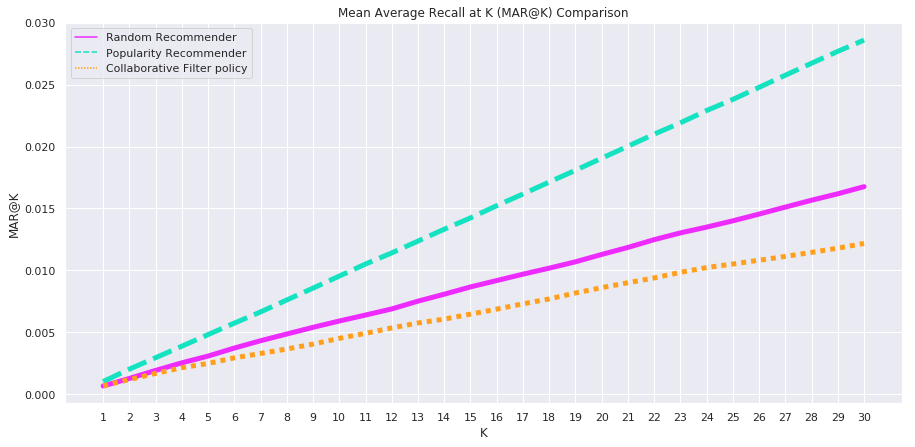

In [34]:
fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [0]:
catalog = train.item_nbr.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

In [0]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter deep-Q']

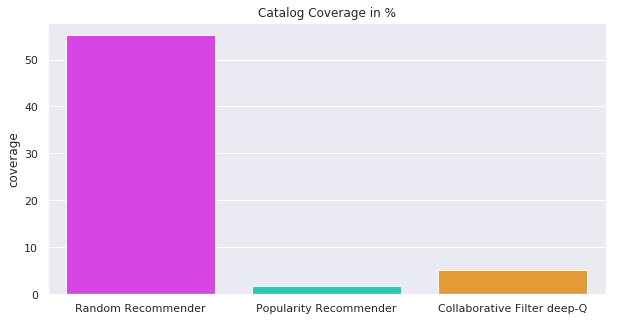

In [38]:
fig = plt.figure(figsize=(10, 5))
recmetrics.coverage_plot(coverage_scores, model_names)
#This figure purpose to shows the coverage of item quantity that predicted by these three different algorithm